# Quantum Hadamard Edge Detection for Image Processing

Based on the paper: "Edge Detection Quantumized: A Novel Quantum Algorithm for Image Processing" [https://arxiv.org/html/2404.06889v1 ](https://arxiv.org/html/2404.06889v1) 

This notebook demonstrates:
1. **QPIE (Quantum Probability Image Encoding)** encoding
2. **QHED (Quantum Hadamard Edge Detection)** algorithm

The encoding was implemented based on this paper: [https://arxiv.org/pdf/1801.01465](https://arxiv.org/pdf/1801.01465)

In [1]:
import math
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from classiq import *

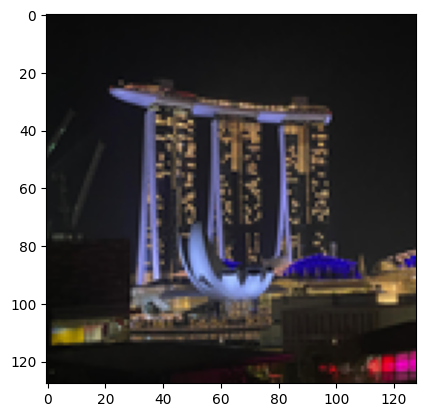

In [2]:
# original
photo = []
photo = plt.imread("Marina Bay Sands 128.png")

plt.imshow(photo)

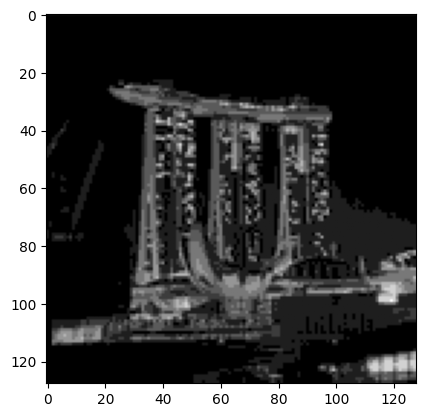

In [3]:
segments = [i / 255 for i in [0, 30, 60, 90, 120, 150, 180, 210, 255]]
image = np.array(photo)
# print(segments)
# print(image)
for i in range(1, len(image)):
    for j in range(len(image[i])):
        pixel = image[i][j][0]
        for s in segments:
            if pixel >= s:
                image[i][j][0] = s
                image[i][j][1] = s
                image[i][j][2] = s
# print("AFTER THE UPDATE")
# print(image)
plt.imshow(image)
image = np.array(photo)

## QPIE Encoding Implementation



Now, convert an image into valid QPIE probability amplitudes. The image is converted to grayscale if needed, flattened to a 1D vector, made non-negative, and L2-normalized so the sum of squared values equals 1.

If the image is all zeros, a uniform normalized vector is returned to avoid division by zero.

In [4]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalize image pixels to create valid probability amplitudes.

    For QPIE, the image is represented as:
    |img⟩ = Σ(x,y) (I_xy / √(Σ I_xy²)) |xy⟩

    Args:
        image: Input image as numpy array

    Returns:
        Normalized probability amplitudes
    """
    # Flatten the image
    flat_image = image.flatten()

    # Normalize to get probability amplitudes
    # Ensure all values are non-negative
    flat_image = np.abs(flat_image)

    # Calculate normalization factor
    norm_factor = np.sqrt(np.sum(flat_image**2))

    if norm_factor == 0:
        # Handle edge case of all-zero image
        normalized = np.ones_like(flat_image) / np.sqrt(len(flat_image))
    else:
        normalized = flat_image / norm_factor

    return normalized


def image_to_qpie_amplitudes(image: np.ndarray) -> List[float]:
    """
    Convert an image to QPIE probability amplitudes.

    Args:
        image: Input image (grayscale or color)

    Returns:
        List of normalized probability amplitudes
    """
    if len(image.shape) == 3:  # Color image
        # Convert to grayscale
        image = np.mean(image, axis=2)

    # Normalize the image
    amplitudes = normalize_image(image)

    return amplitudes.tolist()


@qfunc
def qpie_encoding(image_qubits: Output[QArray[QBit]]):
    """
    QPIE (Quantum Probability Image Encoding) implementation.

    Encodes image pixels as probability amplitudes:
    |img⟩ = Σ c_i |i⟩

    where c_i are normalized pixel values.

    Args:
        amplitudes: Normalized pixel values as probability amplitudes
        image_qubits: Output qubits storing the encoded image
    """
    # Calculate number of qubits needed
    num_pixels = len(AMPLITUDES)
    num_qubits = math.ceil(math.log2(num_pixels))

    # Allocate qubits for image encoding
    allocate(num_qubits, image_qubits)

    # Use inplace_prepare_amplitudes to encode the amplitudes
    inplace_prepare_amplitudes(AMPLITUDES, 0, image_qubits)

In [5]:
amplitudes = image_to_qpie_amplitudes(image)
# print(f"{amplitudes=}")

In [6]:
len(amplitudes)

16384

## Modified QHED Algorithm

The QHED algorithm detects edges by:
1. Adding an auxiliary qubit in $|+\rangle$ state
2. Applying amplitude permutation to shift pixels
3. Applying Hadamard to compute differences
4. Measuring to get edge information

In [7]:
from classiq.qmod.symbolic import logical_or


@qfunc
def quantum_edge_detection_scalable(
    # n_qubits: CInt,  # Number of position qubits
    edge_aux: Output[QBit],
    position: Output[QNum],
):

    # We use the QPIE encoding to encode the image in the quantum state
    qpie_encoding(image_qubits=position)

    # Create the vertical and horizontal correlation checks
    horizontal_edge = QBit()
    vertical_edge = QBit()
    allocate(horizontal_edge)
    allocate(vertical_edge)

    # QHED edge detection
    within_apply(
        within=lambda: H(horizontal_edge),
        apply=lambda: (
            control(
                horizontal_edge, lambda: inplace_add(-1, position)
            ),  # Cyclic shift one left
        ),
    )
    within_apply(
        within=lambda: H(vertical_edge),
        apply=lambda: (
            control(
                vertical_edge, lambda: inplace_add(-n, position)
            ),  # Cyclic shift one up
        ),
    )

    edge_aux |= logical_or(horizontal_edge, vertical_edge)
    drop(horizontal_edge)
    drop(vertical_edge)


# Create and synthesize the 2x2 model

AMPLITUDES = amplitudes
n = int(np.sqrt(len(AMPLITUDES)))
print(f"Creating {n}x{n} image edge detection model...")

Creating 128x128 image edge detection model...


## Synthesize and Analyze the Quantum Circuit

The model is synthesized with a 20-qubit width limit and a long timeout, and finally exported as quantum_image_edge_detection with 15-digit numeric precision.

In [8]:
@qfunc
def main(
    pos: Output[QNum],
    edge_aux: Output[QNum],
):
    quantum_edge_detection_scalable(edge_aux=edge_aux, position=pos)

In [8]:
qprog = synthesize(
    main,
    constraints=Constraints(max_width=20),
    preferences=Preferences(timeout_seconds=14400),
)

In [9]:
print(f"\n{n}x{n} Image Circuit Statistics:")
print(f"  - Number of qubits: {qprog.data.width}")
print(f"  - Circuit depth: {qprog.transpiled_circuit.depth}")
print(
    f"  - Number of gates: {qprog.transpiled_circuit.count_ops if hasattr(qprog.transpiled_circuit, 'count_ops') else 'N/A'}"
)


128x128 Image Circuit Statistics:
  - Number of qubits: 17
  - Circuit depth: 32995
  - Number of gates: {'u': 16903, 'cx': 16878}


In [10]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36qAK2Al0RP6zgLHxrbafMRglxX


In [11]:
qprog = set_quantum_program_execution_preferences(
    qprog, preferences=ExecutionPreferences(num_shots=200000)
)
res = execute(qprog).result()[0].value
res.dataframe

,pos,edge_aux,count,probability,bitstring
0,11710,0,173,0.000865,010110110111110
1,11839,0,169,0.000845,010111000111111
2,11316,0,162,0.000810,010110000110100
3,11712,0,162,0.000810,010110111000000
4,11711,0,159,0.000795,010110110111111
...,...,...,...,...,...
17285,16371,1,1,0.000005,111111111110011
17286,16372,1,1,0.000005,111111111110100
17287,16375,1,1,0.000005,111111111110111
17288,16376,1,1,0.000005,111111111111000


## Create Edge Image From Measurement Results

If ["edge_aux"] == 1 then it is marked as an edge pixel. The new amplitude is calculated based on the number of shots measured for that pixel, normalized by the total number of shots.

In [12]:
new_amplitudes = dict()
for pos in range(len(AMPLITUDES)):
    new_amplitudes[pos] = 0

num_shots = sum([pc.shots for pc in res.parsed_counts])

# if marked as edge, set new amplitude normalized
for pc in res.parsed_counts:
    if pc.state["edge_aux"] == 1:
        new_amplitudes[pc.state["pos"]] = float(np.sqrt(pc.shots / num_shots))
# set amplitude in image of edges
edge_image = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        edge_image[i, j] = new_amplitudes[n * i + j]

Analyze amplitude distributions

(array([1.2809e+04, 0.0000e+00, 2.0090e+03, 4.9500e+02, 5.3900e+02,
        3.1900e+02, 1.4400e+02, 5.1000e+01, 1.6000e+01, 2.0000e+00]),
 array([0.        , 0.00109545, 0.00219089, 0.00328634, 0.00438178,
        0.00547723, 0.00657267, 0.00766812, 0.00876356, 0.00985901,
        0.01095445]),
 <BarContainer object of 10 artists>)

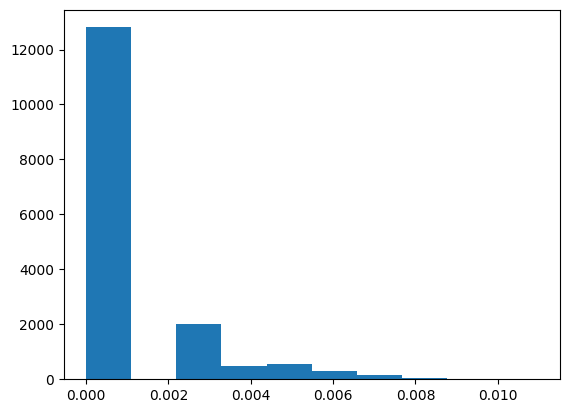

In [13]:
plt.hist(new_amplitudes.values())

Some amplitudes are extremely small and can be treated as noise; discarding them yields a cleaner edge image.

In [14]:
edge_image = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        edge_image[i, j] = (
            new_amplitudes[n * i + j] if new_amplitudes[n * i + j] > 0.003 else 0
        )

(array([7454., 4363., 1308.,  942.,  786.,  677.,  426.,  252.,  118.,
          58.]),
 array([0.00054111, 0.00337295, 0.00620478, 0.00903661, 0.01186845,
        0.01470028, 0.01753211, 0.02036395, 0.02319578, 0.02602761,
        0.02885945]),
 <BarContainer object of 10 artists>)

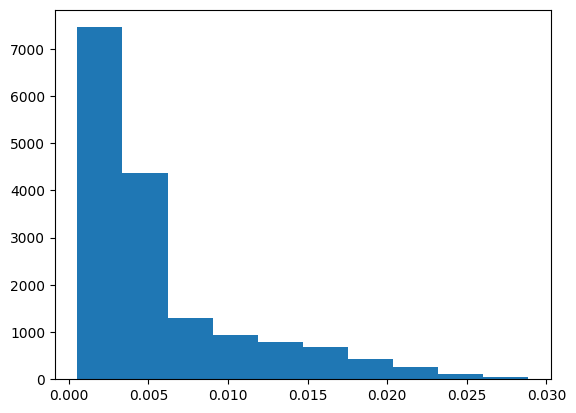

In [15]:
plt.hist(AMPLITUDES)

The resulting edge-detected image

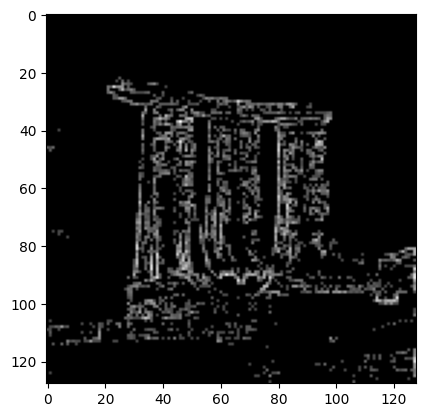

In [16]:
plt.imshow(edge_image, cmap="gray")  # , cmap="gray")

In comparison, the original image is:

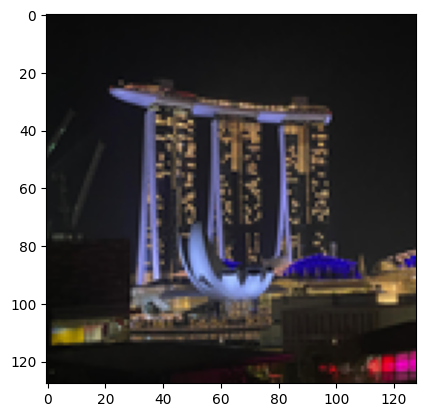

In [17]:
plt.imshow(image)